# Reinforcement Learning Agent for Statistical Arbitrage

This notebook demonstrates how to configure and train a reinforcement learning agent for statistical arbitrage using a snapshot model. The agent will learn to identify and exploit statistical arbitrage opportunities in financial markets.

## Install Packages

The following libraries are required for this notebook. If you haven't installed them yet, you can do so using running the cell below or by using pip install in your terminal.

In [1]:
# Uncomment and install packages once
# %pip -q install -U numpy pandas pyarrow gdown gymnasium stable-baselines3 torch matplotlib tensorboard

## Import Libraries

In [2]:
import os
import json
from gdown import download
import math
import random
import pytz
import itertools

from datetime import datetime

from typing import Tuple, Set, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# Reinforcement Learning
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor

# Deep Learning
import torch

print("Imports complete.")

Imports complete.


## Configuration

The configuration section sets up the parameters for the reinforcement learning model.

In [3]:
CONFIG = {
    "DATA": {
        "forward_fill": True,
        "drop_na_after_ffill": True,
        "cache_dir": "./data_cache",
        "timestamp_format": "%Y-%m-%d %H:%M:%S",
        "asset_price_format": "{ASSET}_{FEATURE}",
        "pair_feature_format": "{ASSET1}_{ASSET2}_{FEATURE}",
        "timestamp_col": "timestamp",
        "sampling": "1m",
        "features": {
            "file_id": "1OCqEkOWV73Z8e-67fpqVL3r3ugVcfml8",
            "file_name": "bin_futures_full_features",
            "type": "csv",
            "seperator": ",",
            "index": "datetime",
            "start": "2024-05-01 00:00:00",
            "end": "2025-05-01 00:00:00",
            "individual_identifier": "close",
            "pair_identifier": "beta",
        },
        "prices": {
            "price_folder_id": "1uXEBUyySypdsW_ZqL-RZ3d1bWdIZisij",
            "ADA_1h": "1ydaR3T68ReE_7j5t3wZbj0F-zdRPYoxg",
            "APT_1h": "1CxG9N2bqWPs9fOPOUryYNtHmONXo4SRi",
            "ARB_1h": "136FSMlAW3XHG8WocxxTEcSKiLMUBwWMi",
            "ATOM_1h": "1mhSQgEwRHn3nvu8Qu1ctQGzdW5JuxATR",
            "BTC_1h": "1-sBNQpEFGEpVO3GDFCkSZiV3Iaqp2vB_",
            "DOGE_1h": "14XlkoQMYr8WWecGninAKUavvjB3qNxk0",
            "DOT_1h": "1kCWB4ZZu3FnadbAquTa3Rcdcwkhnq6-s",
            "ENA_1h": "1TYTxexlD24cs7qmhyVoTacX7lqGOsfky",
            "ETC_1h": "1coBd9QiEX03MndMgX5_549mOPyY23ZcI",
            "ETH_1h": "1kj8G1scpFuEYTTXKEUzF9pwgGI2WFFL9",
            "HBAR_1h": "1LVseecBvXKl3Wl9hbPLsROYKR1Gp8zhQ",
            "LINK_1h": "1ZLEraxdV3H8jpf1FmPeVs1ySL7TzMvH5",
            "LTC_1h": "18d3_jD-tuYTQQR2QOwXupckeDgqvAIvx",
            "NEAR_1h": "1PqI2hD2gbDxUaRDPnJpvDNH5wPYv47G6",
            "SOL_1h": "17CjYYSEsTEqBdmm51zGLgmpkslxxjiji",
            "SUI_1h": "1bToOJts-x2Ia48tqXcMs4qFIQ5OV1lAP",
            "TON_1h": "1SARYo5zB6AunG82kw7KGF4Nird3lQ4zB",
            "TRX_1h": "1FlcZo1WRtKFQMbBrsb61Lp3_pplISW4U",
            "UNI_1h": "15L-eKWliyg9MBKuznlZZ-FJzm52Ovt20",
            "WLD_1h": "1XqD1K4-YZzPxYFHKHY3KmKWnnwi3zO20",
            "XLM_1h": "1_3E5-mORLWh3X16Hi0ccHwzVKg5QxoT4",
            "XRP_1h": "1crt2g_t0qpYnaGpcozl35yDeHhd4tmi4"
        }
    },
    "ENV": {
        "include_cash": True,
        "shorting": True,
        "trading_window_days": "2D",
        "sliding_window_step": "1D",
        "lookback_window": 24,
        "transaction_costs": {
            "commission_bps": 5.0,
            "slippage_bps": 5.0,
        },
        "reward": {
            "risk_lambda": 0.001
        },
        "constraints": {
            "min_weight": -1.0,  # full short
            "max_weight": 1.0,   # full long
            "sum_to_one": False
        },
        "seed": 42
    },
    "SPLITS": {
        "data_start": "2024-05-01",
        "data_end": "2025-04-30",
        "train": ["2024-05-01","2024-05-15"],
        "val": ["2024-05-16","2024-05-23"],
    },
    "RL": {
        "timesteps": 5000,
        "policy": "MlpPolicy",
        "gamma": 0.99,
        "gae_lambda": 0.95,
        "clip_range": 0.2,
        "n_steps": 64,
        "batch_size": 32,
        "learning_rate": 3e-4,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "max_grad_norm": 0.5
    },
    "EVAL": {
        "plots": True,
        "reports_dir": "./reports"
    },
    "IO": {
        "models_dir": "./models",
        "tb_logdir": "./tb_logs"
    }
}

## Helper Functions

In [4]:
# set annualization factors for different timeframes
ANNUALIZATION = {"1m":365*24*60,
                 "5m":365*24*12,
                 "15m":365*24*4,
                 "1h":365*24,
                 "1d":365}

# create directory if it doesn't already exist
def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)

## Set Computation Device

This section sets the computation device for training the model. It checks if a GPU is available and sets it as the device; otherwise, it defaults to CPU.

In [5]:
# run on cuda GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")

# run on Apple Silicon GPU
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is available. Using Apple Silicon GPU.")

# run on CPU (slow)
else:
    device = torch.device("cpu")
    print("CUDA and MPS are not available. Using CPU.")

MPS is available. Using Apple Silicon GPU.


## Set Seeds

This section sets the random seeds for various libraries to ensure that the results are reproducible.

Note: It is good practice to type (set data types) for function and method parameters for better code maintainability.

In [6]:
def set_all_seeds(seed: int = 42):
    random.seed(seed) # seed for random module
    np.random.seed(seed) # seed for numpy module
    try:
        torch.manual_seed(seed) # seed for torch module
        if torch.cuda.is_available(): # seed for CUDA device
            torch.cuda.manual_seed_all(seed)
        elif torch.backends.mps.is_available(): # seed for Apple Silicon device
            torch.backends.mps.manual_seed_all(seed)
    except Exception:
        pass

set_all_seeds(CONFIG["ENV"]["seed"]) # set all seeds for reproducibility

## Download Feature Data

In this section, we retrieve the .csv file created during feature engineering.

In [7]:
def download_file(file_name: str, file_id: str, out_dir: str):
    ensure_dir(out_dir)

    out_path = os.path.join(out_dir, f"{file_name}.csv")  # full output path

    if os.path.exists(out_path):
        print(f"Skipping download. File {file_name} already exists in cache.")
        return

    try:
        print(f"Downloading {file_name} -> {out_path}")
        url = f"https://drive.google.com/uc?id={file_id}"
        success = download(url, out_path, quiet=False, use_cookies=False, verify=True)
        print("Download complete.")
        return success
    except Exception as e:
        print(f"Download attempt failed for {file_name}. Error: {str(e)}")
    
# donwload features
file_name = CONFIG["DATA"]["features"]["file_name"]
file_id = CONFIG["DATA"]["features"]["file_id"]
cache_dir = CONFIG["DATA"]["cache_dir"]

success = download_file(file_name, file_id, cache_dir)

Skipping download. File bin_futures_full_features already exists in cache.


## Load Feature Data

Once the data is downloaded, this section loads the data into a pandas DataFrame for later processing.

In [8]:
def load_csv_to_df(
    path: str,
    sep: str = ",",
    timestamp_index_col: str | None = "datetime",
    encoding: str = "utf-8-sig",
    **read_csv_kwargs,
) -> pd.DataFrame:
    """
    Load a CSV into a pandas DataFrame.

    Parameters
    ----------
    path : str
        Filesystem path to the CSV.
    parse_timestamp_col : str | None
        If provided and present in the CSV, this column will be parsed to datetime.
        Set to None to skip datetime parsing.
    **read_csv_kwargs :
        Extra arguments passed to `pd.read_csv` (e.g., sep, dtype, usecols).

    Returns
    -------
    pd.DataFrame
    """

    # Parse header-only to check for timestamp col presence
    head = pd.read_csv(path, sep=sep, encoding=encoding, nrows=0)
    if timestamp_index_col and timestamp_index_col in head.columns:
        read_csv_kwargs = {
            **read_csv_kwargs,
            "parse_dates": [timestamp_index_col],
        }

    df = pd.read_csv(path, sep=sep, encoding=encoding, engine="pyarrow", **read_csv_kwargs)

    df = df.set_index("datetime")

    return df


# load features
file_name = CONFIG["DATA"]["features"]["file_name"]
cache_dir = CONFIG["DATA"]["cache_dir"]
index = CONFIG["DATA"]["features"]["index"]
sep = CONFIG["DATA"]["features"].get("seperator", ",")
file_path = os.path.join(cache_dir, f"{file_name}.csv")
features_df = load_csv_to_df(file_path, sep, timestamp_index_col=index)

# print dataframe info
print("Features DataFrame Info:")
print(features_df.info())

Features DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 525600 entries, 2024-05-01 00:00:00 to 2025-04-30 23:59:00
Columns: 789 entries, AAVE_close to XRP_fundingMinutesLeft
dtypes: float64(763), int64(25), object(1)
memory usage: 3.1+ GB
None


## Identify Feature Structure

In [9]:
def identify_assets_features_pairs(
    df: pd.DataFrame,
    single_asset_format: str,
    pair_feature_format: str,
) -> tuple[list[str], list[str], list[str], list[tuple[str, str]]]:
    """
    Returns distinct
      1. assets
      2. single-asset feature names (ARB_closeUpperShadow → closeUpperShadow)
      3. pair feature names (ARB_ETH_spreadNorm → spreadNorm)
      4. unordered asset pairs
    """

    def format_to_regex(fmt: str) -> re.Pattern:
        escaped = re.escape(fmt)

        def repl(match: re.Match[str]) -> str:
            name = match.group(1)
            char_class = r"[A-Za-z0-9_]+" if "FEATURE" in name.upper() else r"[A-Za-z0-9]+"
            return f"(?P<{name}>{char_class})"

        escaped = re.sub(r"\\\{(\w+)\\\}", repl, escaped)
        return re.compile(f"^{escaped}$")

    single_asset_pattern = format_to_regex(single_asset_format)
    pair_feature_pattern = format_to_regex(pair_feature_format)
    generic_single_pattern = re.compile(r"^(?P<ASSET>[A-Za-z0-9]+)_(?P<FEATURE>[A-Za-z0-9_]+)$")

    assets: Set[str] = set()
    single_features: Set[str] = set()
    pair_features: Set[str] = set()
    pairs: Set[Tuple[str, str]] = set()

    literal_feature = None
    if "{FEATURE}" not in single_asset_format:
        literal_feature = single_asset_format.replace("{ASSET}", "").lstrip("_")

    skip_cols = {"timestamp", "datetime", "date"}

    for col in df.columns:
        if col in skip_cols:
            continue

        match_pair = pair_feature_pattern.match(col)
        if match_pair:
            a1, a2, feat = match_pair.group("ASSET1"), match_pair.group("ASSET2"), match_pair.group("FEATURE")
            assets.update((a1, a2))
            pairs.add(tuple(sorted((a1, a2))))
            pair_features.add(feat)
            continue

        match_single = single_asset_pattern.match(col)
        if match_single:
            asset = match_single.group("ASSET")
            assets.add(asset)
            feat = match_single.groupdict().get("FEATURE") or literal_feature
            if feat:
                single_features.add(feat)
            continue

        match_generic = generic_single_pattern.match(col)
        if match_generic:
            asset, feat = match_generic.group("ASSET"), match_generic.group("FEATURE")
            assets.add(asset)
            single_features.add(feat)
            continue

    return (
        sorted(assets),
        sorted(single_features),
        sorted(pair_features),
        sorted(pairs),
    )

# identify assets, features, and asset pairs
single_asset_format = CONFIG["DATA"]["asset_price_format"]
pair_feature_format = CONFIG["DATA"]["pair_feature_format"]
assets, single_asset_features, pair_features, asset_pairs = identify_assets_features_pairs(
    features_df,
    CONFIG["DATA"]["asset_price_format"],
    CONFIG["DATA"]["pair_feature_format"],
)

print(f"Identified {len(assets)} assets: {assets}")
print(f"Identified {len(asset_pairs)} asset pairs: {asset_pairs}")
print(f"Identified {len(single_asset_features)} single-asset features: {single_asset_features}")
print(f"Identified {len(pair_features)} pair features: {pair_features}")

Identified 25 assets: ['AAVE', 'ADA', 'APT', 'ARB', 'ATOM', 'AVAX', 'BCH', 'BNB', 'BTC', 'DOGE', 'DOT', 'ENA', 'ETC', 'ETH', 'HBAR', 'LINK', 'LTC', 'NEAR', 'SUI', 'TON', 'TRX', 'UNI', 'WLD', 'XLM', 'XRP']
Identified 61 asset pairs: [('AAVE', 'SUI'), ('AAVE', 'TRX'), ('ADA', 'BTC'), ('ADA', 'DOGE'), ('ADA', 'HBAR'), ('ADA', 'LTC'), ('ADA', 'SUI'), ('ADA', 'XLM'), ('ADA', 'XRP'), ('APT', 'AVAX'), ('ARB', 'ATOM'), ('ARB', 'AVAX'), ('ARB', 'DOT'), ('ARB', 'ETC'), ('ARB', 'ETH'), ('ARB', 'NEAR'), ('ARB', 'WLD'), ('ATOM', 'BCH'), ('ATOM', 'DOT'), ('ATOM', 'ENA'), ('ATOM', 'ETC'), ('AVAX', 'BCH'), ('AVAX', 'DOT'), ('AVAX', 'ETC'), ('AVAX', 'UNI'), ('BCH', 'DOT'), ('BCH', 'ENA'), ('BCH', 'ETC'), ('BNB', 'LINK'), ('BTC', 'DOGE'), ('BTC', 'HBAR'), ('BTC', 'LTC'), ('BTC', 'SUI'), ('BTC', 'TRX'), ('BTC', 'XLM'), ('BTC', 'XRP'), ('DOGE', 'LINK'), ('DOGE', 'LTC'), ('DOGE', 'SUI'), ('DOGE', 'XLM'), ('DOT', 'ENA'), ('DOT', 'ETC'), ('DOT', 'ETH'), ('ENA', 'ETC'), ('ENA', 'UNI'), ('ETC', 'ETH'), ('ETC',

## Build Time Intervals

In [10]:
def build_time_intervals(
    df: pd.DataFrame,
    window: pd.Timedelta | str,
    step: Optional[pd.Timedelta | str] = None,
    timestamp_col: str = "datetime",
    include_last_partial: bool = False,
) -> list[tuple[pd.Timestamp, pd.Timestamp]]:
    """
    Return fixed-length time intervals over the DataFrame's time span.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain a datetime-like 'timestamp' column or have a DatetimeIndex.
    window : pd.Timedelta | str
        Size of each window, e.g. '2D', '60min', '15T'.
    step : pd.Timedelta | str | None
        Step between consecutive window starts. Defaults to `window` (non-overlapping).
        Use a smaller step than `window` for sliding/overlapping windows.
    timestamp_col : str
        Name of the timestamp column (ignored if index is a DatetimeIndex).
    include_last_partial : bool
        If True, include the trailing partial window shorter than `window`.

    Returns
    -------
    list[tuple[pd.Timestamp, pd.Timestamp]]
        Half-open intervals [start, end).
    """
    W = pd.Timedelta(window)
    S = pd.Timedelta(step) if step is not None else W

    # Extract, sanitize, and sort timestamps
    if timestamp_col in df.columns:
        ts = pd.to_datetime(df[timestamp_col]).dropna().sort_values()
    elif isinstance(df.index, pd.DatetimeIndex):
        ts = pd.Series(df.index).dropna().sort_values()
    else:
        raise ValueError(
            f"Timestamp column '{timestamp_col}' not found and index is not DatetimeIndex."
        )

    intervals: list[tuple[pd.Timestamp, pd.Timestamp]] = []
    if ts.empty:
        return intervals

    t_min = ts.iloc[0]
    t_max = ts.iloc[-1]
    cur = t_min

    while cur < t_max:
        end = cur + W
        if end <= t_max:
            intervals.append((cur, end))
        elif include_last_partial:
            intervals.append((cur, t_max))
            break
        else:
            break
        cur = cur + S

    return intervals

# build intervals
window = CONFIG["ENV"]["trading_window_days"]
step = CONFIG["ENV"]["sliding_window_step"]
timestamp_col = CONFIG["DATA"]["timestamp_col"]

intervals = build_time_intervals(
    features_df,
    window,
    step,
    timestamp_col,
    include_last_partial=False
)

# print interval info
print(f"Built {len(intervals)} time intervals with window={window} and step={step}.")
print("First 3 intervals:")
for start, end in intervals[:3]:
    print(f"  {start} to {end}")

Built 363 time intervals with window=2D and step=1D.
First 3 intervals:
  2024-05-01 00:00:00 to 2024-05-03 00:00:00
  2024-05-02 00:00:00 to 2024-05-04 00:00:00
  2024-05-03 00:00:00 to 2024-05-05 00:00:00


## Identify Feature Space

In [11]:
def is_timeframe_valid(
    df: pd.DataFrame,
    pair: tuple[str, str],
    start: pd.Timestamp,
    end: pd.Timestamp,
    feature_name: str,
    pair_feature_format: str = "{ASSET1}_{ASSET2}_{FEATURE}",
    timestamp_col: str | None = "datetime",
) -> bool:
    """
    Check if the given time frame has complete data for the specified asset pair.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the data.
    pair : tuple[str, str]
        Asset pair (asset1, asset2).
    start : pd.Timestamp
        Start of the time frame (inclusive).
    end : pd.Timestamp
        End of the time frame (exclusive).
    pair_feature_format : str
        Format string for pair-feature columns (e.g., "{ASSET1}_{ASSET2}_{FEATURE}").
    timestamp_col : str
        Name of the timestamp column.

    Returns
    -------
    bool
        True if the time frame is valid (no missing data), False otherwise.
    """
    feature_col = pair_feature_format.format(
        ASSET1=pair[0], ASSET2=pair[1], FEATURE=feature_name
    )

    if timestamp_col and timestamp_col in df.columns:
        ts = df[timestamp_col]
    else:
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError(
                "DataFrame neither has the timestamp column nor a DatetimeIndex."
            )
        ts = df.index

    mask = (ts >= start) & (ts < end)
    if mask.sum() == 0:
        return False

    data_slice = df.loc[mask, feature_col]
    return not data_slice.isna().any()


pair_identifier = CONFIG["DATA"]["features"]["pair_identifier"]

valid_intervals_per_pair = {}
for pair in asset_pairs:
    valid_intervals = []
    for start, end in intervals:
        if is_timeframe_valid(
            features_df,
            pair,
            start,
            end,
            feature_name=pair_identifier,
            pair_feature_format=pair_feature_format,
            timestamp_col=timestamp_col):

            valid_intervals.append((start, end))
    valid_intervals_per_pair[pair] = valid_intervals
    print(f"Pair {pair} has {len(valid_intervals)} valid intervals out of {len(intervals)} total intervals.")

Pair ('AAVE', 'SUI') has 6 valid intervals out of 363 total intervals.
Pair ('AAVE', 'TRX') has 2 valid intervals out of 363 total intervals.
Pair ('ADA', 'BTC') has 6 valid intervals out of 363 total intervals.
Pair ('ADA', 'DOGE') has 15 valid intervals out of 363 total intervals.
Pair ('ADA', 'HBAR') has 25 valid intervals out of 363 total intervals.
Pair ('ADA', 'LTC') has 7 valid intervals out of 363 total intervals.
Pair ('ADA', 'SUI') has 7 valid intervals out of 363 total intervals.
Pair ('ADA', 'XLM') has 9 valid intervals out of 363 total intervals.
Pair ('ADA', 'XRP') has 11 valid intervals out of 363 total intervals.
Pair ('APT', 'AVAX') has 6 valid intervals out of 363 total intervals.
Pair ('ARB', 'ATOM') has 11 valid intervals out of 363 total intervals.
Pair ('ARB', 'AVAX') has 9 valid intervals out of 363 total intervals.
Pair ('ARB', 'DOT') has 12 valid intervals out of 363 total intervals.
Pair ('ARB', 'ETC') has 20 valid intervals out of 363 total intervals.
Pair ('

## Feature Panel Creation

In [12]:
def create_feature_panel(
    df: pd.DataFrame,
    assets: list[str],
    single_asset_features: list[str],
    pair_features: list[str],
    asset_pairs: list[tuple[str, str]],
    pair_feature_format: str,
    timestamp_col: str | None = "datetime",
) -> pd.DataFrame:
    """Assemble a MultiIndex feature panel from pre-normalized inputs."""
    if timestamp_col and timestamp_col in df.columns:
        working_df = df.set_index(timestamp_col)
    else:
        working_df = df
        if not isinstance(working_df.index, pd.DatetimeIndex):
            raise ValueError(
                "DataFrame needs either `timestamp_col` or a DatetimeIndex in order to build the panel."
            )

    panel_columns: list[tuple[str, str]] = []
    panel_series: list[pd.Series] = []

    for asset in assets:
        for feature in single_asset_features:
            col_name = f"{asset}_{feature}"
            if col_name in working_df.columns:
                panel_series.append(working_df[col_name])
                panel_columns.append((asset, feature))

    for asset1, asset2 in asset_pairs:
        for feature in pair_features:
            col_name = pair_feature_format.format(
                ASSET1=asset1, ASSET2=asset2, FEATURE=feature
            )
            if col_name in working_df.columns:
                panel_series.append(working_df[col_name])
                panel_columns.append((f"{asset1}_{asset2}", feature))

    if not panel_series:
        raise ValueError("No matching feature columns found to construct the panel.")

    panel = pd.concat(panel_series, axis=1)
    panel.columns = pd.MultiIndex.from_tuples(panel_columns, names=["asset", "feature"])
    return panel.fillna(0)


# Create feature panel
panel = create_feature_panel(
    features_df,
    assets,
    single_asset_features,
    pair_features,
    asset_pairs,
    CONFIG["DATA"]["pair_feature_format"],
)

print("Feature panel structure:")
print("\nShape:", panel.shape)
print("\nSample of the data:")
print(panel.head())

Feature panel structure:

Shape: (525600, 788)

Sample of the data:
asset                    AAVE                                     \
feature                 close closeBias closeEwmaVol closeKalman   
datetime                                                           
2024-05-01 00:00:00  4.423169       0.0          0.0         0.0   
2024-05-01 00:01:00  4.422809       0.0          0.0         0.0   
2024-05-01 00:02:00  4.421368       0.0          0.0         0.0   
2024-05-01 00:03:00  4.422929       0.0          0.0         0.0   
2024-05-01 00:04:00  4.422569       0.0          0.0         0.0   

asset                                                               \
feature             closeLowerShadow closeMacd closeRsi closeSigns   
datetime                                                             
2024-05-01 00:00:00              0.0       0.0      0.0        0.0   
2024-05-01 00:01:00              0.0       0.0      0.0        0.0   
2024-05-01 00:02:00              0.0 

## Feature scaling and state tensor construction

This section normalizes the features and constructs the state tensors required for training the reinforcement learning agent. State tensors are multi-dimensional arrays that represent the current state of the environment that the RL agent uses to make decisions.

In [13]:
def build_state_tensor_for_interval(
        panel: pd.DataFrame,
        pair: tuple,
        start: pd.Timestamp,
        end: pd.Timestamp,
        lookback: int
) -> tuple[Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray], Optional[pd.DatetimeIndex]]:
    """Build state tensor for a specific time interval and asset pair."""
    asset1, asset2 = pair
    pair_str = f"{asset1}_{asset2}"

    # Build consistent column ordering: asset1 features, asset2 features, then pair features
    asset1_columns = sorted([col for col in panel.columns if col[0] == asset1], key=lambda x: x[1])
    asset2_columns = sorted([col for col in panel.columns if col[0] == asset2], key=lambda x: x[1])
    pair_columns = sorted([col for col in panel.columns if col[0] == pair_str], key=lambda x: x[1])
    selected_columns = asset1_columns + asset2_columns + pair_columns

    if not selected_columns:
        return None, None, None, None, None

    # Convert index to DatetimeIndex if it isn't already
    if not isinstance(panel.index, pd.DatetimeIndex):
        if 'datetime' in panel.columns:
            panel = panel.set_index('datetime')
        else:
            raise ValueError("Panel must have either a DatetimeIndex or a 'datetime' column")

    # Ensure index is timezone-aware UTC
    if panel.index.tz is None:
        panel.index = panel.index.tz_localize('UTC')
    elif panel.index.tz != pytz.UTC:
        panel.index = panel.index.tz_convert('UTC')

    start_ts = pd.Timestamp(start)
    end_ts = pd.Timestamp(end)
    if start_ts.tzinfo is None:
        start_ts = start_ts.tz_localize('UTC')
    else:
        start_ts = start_ts.tz_convert('UTC')
    if end_ts.tzinfo is None:
        end_ts = end_ts.tz_localize('UTC')
    else:
        end_ts = end_ts.tz_convert('UTC')

    # Create mask for time window (half-open interval)
    mask = (panel.index >= start_ts) & (panel.index < end_ts)
    window_data = panel.loc[mask, selected_columns]

    if len(window_data) < lookback + 1:
        return None, None, None, None, None

    pair_identifier = CONFIG["DATA"]["features"]["pair_identifier"]
    individual_identifier = CONFIG["DATA"]["features"]["individual_identifier"]

    pair_identifier_key = (pair_str, pair_identifier)
    asset1_price_key = (asset1, individual_identifier)
    asset2_price_key = (asset2, individual_identifier)

    required_keys = (pair_identifier_key, asset1_price_key, asset2_price_key)
    if any(key not in selected_columns for key in required_keys):
        return None, None, None, None, None

    # Prepare dimensions
    n_samples = len(window_data) - lookback
    if n_samples <= 0:
        return None, None, None, None, None

    n_features = len(selected_columns)

    # Initialize tensors
    X = np.zeros((n_samples, 1, n_features, lookback), dtype=np.float32)
    R = np.zeros((n_samples, 1), dtype=np.float32)
    VOL = np.zeros((n_samples, 1), dtype=np.float32)
    asset_returns = np.zeros((n_samples, 2), dtype=np.float32)

    data_values = window_data.values
    feature_to_idx = {col: idx for idx, col in enumerate(selected_columns)}
    asset1_idx = feature_to_idx[asset1_price_key]
    asset2_idx = feature_to_idx[asset2_price_key]

    eps = 1e-12
    asset1_values = data_values[:, asset1_idx].astype(np.float64)
    asset2_values = data_values[:, asset2_idx].astype(np.float64)

    for t in range(n_samples):
        X[t, 0, :, :] = data_values[t:t + lookback].T

        curr_a1 = asset1_values[t + lookback - 1]
        next_a1 = asset1_values[t + lookback]
        curr_a2 = asset2_values[t + lookback - 1]
        next_a2 = asset2_values[t + lookback]

        ret_a1 = (next_a1 - curr_a1) / (abs(curr_a1) + eps)
        ret_a2 = (next_a2 - curr_a2) / (abs(curr_a2) + eps)
        asset_returns[t, 0] = ret_a1
        asset_returns[t, 1] = ret_a2

        pair_step_return = ret_a1 - ret_a2
        R[t, 0] = pair_step_return

        window_a1 = asset1_values[t:t + lookback + 1]
        window_a2 = asset2_values[t:t + lookback + 1]
        window_ret_a1 = np.diff(window_a1) / (np.abs(window_a1[:-1]) + eps)
        window_ret_a2 = np.diff(window_a2) / (np.abs(window_a2[:-1]) + eps)
        pair_window_ret = window_ret_a1 - window_ret_a2
        if pair_window_ret.size > 0:
            VOL[t, 0] = float(np.sqrt(np.mean(pair_window_ret ** 2)))
        else:
            VOL[t, 0] = 0.0

    sample_times = window_data.index[lookback:]
    if sample_times.tz is None:
        sample_times = sample_times.tz_localize('UTC')
    elif sample_times.tz != pytz.UTC:
        sample_times = sample_times.tz_convert('UTC')

    return X, R, VOL, asset_returns, sample_times

# Initialize lists to store tensors and metadata
all_X, all_R, all_VOL = [], [], []
all_asset_returns = []
all_pairs = []
all_features = set()
all_timestamps = []
sample_timestamp_list = []
ticker_set = set()  # Keep track of unique tickers

# Process each pair and its valid intervals
total_pairs = len(valid_intervals_per_pair)
for pair_idx, (pair, intervals) in enumerate(valid_intervals_per_pair.items(), 1):

    # Add both assets to the ticker set
    ticker_set.update(pair)

    skipped_intervals = 0
    valid_intervals = 0
    asset1, asset2 = pair
    pair_str = f"{asset1}_{asset2}"

    for interval_idx, (start, end) in enumerate(intervals, 1):

        X, R, VOL, asset_ret, sample_times = build_state_tensor_for_interval(
            panel, pair, start, end, CONFIG["ENV"]["lookback_window"]
        )

        if X is not None:
            all_X.append(X)
            all_R.append(R)
            all_VOL.append(VOL)
            all_asset_returns.append(asset_ret)
            all_pairs.append(pair)
            all_timestamps.append((start, end))
            sample_timestamp_list.extend(sample_times)

            selected_columns = (
                sorted([col for col in panel.columns if col[0] == asset1], key=lambda x: x[1]) +
                sorted([col for col in panel.columns if col[0] == asset2], key=lambda x: x[1]) +
                sorted([col for col in panel.columns if col[0] == pair_str], key=lambda x: x[1])
            )
            feature_labels = [f"{col[0]}::{col[1]}" for col in selected_columns]
            all_features.update(feature_labels)

            valid_intervals += 1
        else:
            skipped_intervals += 1
    print(f"Finished pair {pair} ({pair_idx}/{total_pairs}). Valid intervals: {valid_intervals}, Skipped intervals: {skipped_intervals}, Total: {len(intervals)}")

# Combine all tensors
if all_X:
    X_all = np.concatenate(all_X, axis=0)
    R_all = np.concatenate(all_R, axis=0)
    VOL_all = np.concatenate(all_VOL, axis=0)
    ASSET_RETURNS_all = np.concatenate(all_asset_returns, axis=0)

    SAMPLE_TIME_INDEX = pd.DatetimeIndex(sample_timestamp_list)
    if SAMPLE_TIME_INDEX.tz is None:
        SAMPLE_TIME_INDEX = SAMPLE_TIME_INDEX.tz_localize('UTC')
    elif SAMPLE_TIME_INDEX.tz != pytz.UTC:
        SAMPLE_TIME_INDEX = SAMPLE_TIME_INDEX.tz_convert('UTC')

    FEAT_ORDER = sorted(list(all_features))
    TICKER_ORDER = sorted(list(ticker_set))  # Create sorted list of unique tickers

    print("Final tensor shapes:")
    print(f"X (states): {X_all.shape}")
    print(f"R (pair returns): {R_all.shape}")
    print(f"Asset returns: {ASSET_RETURNS_all.shape}")
    print(f"VOL (volatilities): {VOL_all.shape}")
    print(f"Total pairs processed: {len(all_pairs)}")
    print(f"Features: {FEAT_ORDER}")
    print(f"Time intervals processed: {len(all_timestamps)}")
    print(f"Samples with timestamps: {len(SAMPLE_TIME_INDEX)}")

    # Print actual date range of processed data
    if all_timestamps:
        all_starts = [start for start, _ in all_timestamps]
        all_ends = [end for _, end in all_timestamps]
        print(f"Actual data range: {min(all_starts)} to {max(all_ends)}")
else:
    print("No valid data found for any pair and interval")


Finished pair ('AAVE', 'SUI') (1/61). Valid intervals: 6, Skipped intervals: 0, Total: 6
Finished pair ('AAVE', 'TRX') (2/61). Valid intervals: 2, Skipped intervals: 0, Total: 2
Finished pair ('ADA', 'BTC') (3/61). Valid intervals: 6, Skipped intervals: 0, Total: 6
Finished pair ('ADA', 'DOGE') (4/61). Valid intervals: 15, Skipped intervals: 0, Total: 15
Finished pair ('ADA', 'HBAR') (5/61). Valid intervals: 25, Skipped intervals: 0, Total: 25
Finished pair ('ADA', 'LTC') (6/61). Valid intervals: 7, Skipped intervals: 0, Total: 7
Finished pair ('ADA', 'SUI') (7/61). Valid intervals: 7, Skipped intervals: 0, Total: 7
Finished pair ('ADA', 'XLM') (8/61). Valid intervals: 9, Skipped intervals: 0, Total: 9
Finished pair ('ADA', 'XRP') (9/61). Valid intervals: 11, Skipped intervals: 0, Total: 11
Finished pair ('APT', 'AVAX') (10/61). Valid intervals: 6, Skipped intervals: 0, Total: 6
Finished pair ('ARB', 'ATOM') (11/61). Valid intervals: 11, Skipped intervals: 0, Total: 11
Finished pair ('

## Define Splits and Adjust Timezones

This section defines the training and validation splits for the dataset. It ensures that the data is divided appropriately to train the model, validate its performance during training, and test its final performance on unseen data. Also, it adjusts the timezones of the datetime indices to ensure consistency across the dataset. This is necessary in case the data comes from multiple sources with different timezone settings.

In [14]:
# function to create boolean mask for date slicing
def date_slice_mask(times: pd.DatetimeIndex, start: str, end: str):
    # convert input dates to UTC timestamps
    start_ts = pd.Timestamp(start).tz_localize('UTC')
    end_ts = pd.Timestamp(end).tz_localize('UTC')
    
    # ensure time index is in UTC
    if times.tz is None: # if naive, localize to UTC
        times = times.tz_localize('UTC')
    elif times.tz != pytz.UTC: # if timezone-aware but not UTC, convert to UTC
        times = times.tz_convert('UTC')
        
    mask = (times >= start_ts) & (times <= end_ts) # return boolean mask for splits later on

    if not mask.any():
        raise ValueError(f"No data points found in period {start} to {end}")
        
    return mask

# Create time splits based on configuration
TIME_INDEX = panel.index

# Create simple train/val split based on CONFIG dates
try:
    train_mask = date_slice_mask(TIME_INDEX, CONFIG["SPLITS"]["train"][0], CONFIG["SPLITS"]["train"][1])
    val_mask = date_slice_mask(TIME_INDEX, CONFIG["SPLITS"]["val"][0], CONFIG["SPLITS"]["val"][1])

    print(f"\nTraining windows: {train_mask.sum()} timesteps")
    print(f"Training period: {TIME_INDEX[train_mask].min()} to {TIME_INDEX[train_mask].max()}")
    
    print(f"\nValidation windows: {val_mask.sum()} timesteps")
    print(f"Validation period: {TIME_INDEX[val_mask].min()} to {TIME_INDEX[val_mask].max()}")

    # Create splits for training
    SPLITS = [{
        "name": "DateSplit",
        "train": train_mask,
        "val": val_mask
    }]
except ValueError as e:
    print("\nError creating splits:", str(e))
    print("\nPlease check your date ranges in CONFIG:")
    print(f"Train: {CONFIG['SPLITS']['train']}")
    print(f"Validation: {CONFIG['SPLITS']['val']}")
    print(f"Data available: {TIME_INDEX.min()} to {TIME_INDEX.max()}")


Training windows: 20161 timesteps
Training period: 2024-05-01 00:00:00+00:00 to 2024-05-15 00:00:00+00:00

Validation windows: 10081 timesteps
Validation period: 2024-05-16 00:00:00+00:00 to 2024-05-23 00:00:00+00:00


## Environment Configuration

This is a custom Gymnasium environment for portfolio optimization.

In [15]:
class PortfolioWeightsEnv(gym.Env):
    metadata = {"render_modes": []}

    def __init__(self, X, pair_returns, asset_returns, VOL, tickers, lookback, cfg_env):
        super().__init__()
        self.X = X  # state tensor (samples, pairs, features, lookback)
        self.pair_returns = pair_returns  # next period pair returns (samples, pairs)
        self.asset_returns = asset_returns  # next period asset returns (samples, assets)
        self.VOL = VOL  # current period volatilities (samples, pairs)
        self.R = self.pair_returns  # backward compatibility
        self.tickers = tickers  # list of assets
        self.lookback = lookback  # lookback window
        self.cfg = cfg_env  # environment configuration taken from CONFIG

        # We'll work with just the first pair for now
        self.active_pair_idx = 0

        self.n_assets = self.asset_returns.shape[1]
        self.include_cash = cfg_env["include_cash"]
        self.shorting = cfg_env["shorting"]
        self.dim_action = self.n_assets + (1 if self.include_cash else 0)

        # Calculate observation space dimension
        n_features = X.shape[2]  # number of features per asset/pair channel
        obs_dim = n_features * lookback  # observation dimension for one pair

        print(f"Features per observation: {n_features}")
        print(f"Observation dimension: {obs_dim}")

        self.observation_space = spaces.Box(
            low=-5,
            high=5,
            shape=(obs_dim,),
            dtype=np.float32
        )

        print(f"Observation space shape: {self.observation_space.shape}")

        # Update action space for assets + optional cash
        min_weight = cfg_env["constraints"]["min_weight"] if self.shorting else 0.0
        max_weight = cfg_env["constraints"]["max_weight"]
        
        self.action_space = spaces.Box(
            low=min_weight,
            high=max_weight,
            shape=(self.dim_action,),
            dtype=np.float32
        )

        print(f"Action space shape: {self.action_space.shape}")

        self.commission = cfg_env["transaction_costs"]["commission_bps"] / 1e4
        self.slippage = cfg_env["transaction_costs"]["slippage_bps"] / 1e4
        self.risk_lambda = cfg_env["reward"]["risk_lambda"]

        self.reset(seed=cfg_env.get("seed", 42))

    def _to_obs(self, t):
        # Get features for the current active pair only
        arr = self.X[t, self.active_pair_idx, :, :].reshape(-1).astype(np.float32)
        return arr

    def _project_weights(self, a):
        min_weight = self.cfg["constraints"]["min_weight"] if self.shorting else 0.0
        max_weight = self.cfg["constraints"]["max_weight"]
        
        # First clip weights to allowed range
        clipped = np.clip(a, min_weight, max_weight)
        
        # Normalize to ensure weights sum to 1.0 if required
        if self.cfg["constraints"]["sum_to_one"]:
            abs_sum = np.sum(np.abs(clipped))
            if abs_sum > 0:
                clipped = clipped / abs_sum
                
        return clipped

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.t = 0
        self.portfolio_value = 1.0
        self.w = np.zeros(self.dim_action)
        if self.include_cash:
            self.w[-1] = 1.0  # start with all cash
        obs = self._to_obs(self.t)
        return obs, {}

    def step(self, action):
        w_target = self._project_weights(action)
        turnover = np.sum(np.abs(w_target - self.w))
        
        # Apply transaction costs progressively
        trading_cost = (self.commission + self.slippage) * turnover
        if trading_cost > 0.1:  # Cap trading costs at 10% to prevent extreme values
            trading_cost = 0.1
            
        asset_w_prev = self.w[:self.n_assets]

        # Get returns and volatility for the active pair
        pair_return = self.pair_returns[self.t, self.active_pair_idx]
        pair_vol = self.VOL[self.t, self.active_pair_idx]
        asset_ret_vec = self.asset_returns[self.t]

        # Calculate portfolio return using both asset weights
        portfolio_asset_return = float(np.dot(asset_ret_vec, asset_w_prev))
        
        # Cap extreme returns
        portfolio_asset_return = np.clip(portfolio_asset_return, -0.5, 0.5)
        
        # Calculate instantaneous volatility with position sizing
        inst_vol = float(pair_vol) * np.sum(np.abs(asset_w_prev))

        # reward function: asset return minus trading costs and risk penalty
        reward = portfolio_asset_return - trading_cost - self.risk_lambda * inst_vol

        # Update portfolio value with safeguards
        total_return = portfolio_asset_return - trading_cost
        self.portfolio_value *= max(0.1, 1.0 + total_return)  # Prevent complete loss

        self.w = w_target
        self.t += 1
        terminated = (self.t >= len(self.pair_returns) - 1)
        truncated = False

        obs = self._to_obs(self.t) if not terminated else self._to_obs(self.t - 1)
        obs = np.clip(obs, -5.0, 5.0)

        info = {
            "portfolio_value": self.portfolio_value,
            "turnover": turnover,
            "inst_vol": inst_vol,
            "asset_return": portfolio_asset_return,
            "pair_return": pair_return,
            "asset_returns": asset_ret_vec,
            "trading_cost": trading_cost
        }
        return obs, reward, terminated, truncated, info

In [16]:
def slice_by_mask(X, pair_R, asset_R, VOL, mask: np.ndarray):
    if len(mask) != len(TIME_INDEX):
        raise ValueError("Mask length does not match reference time index")

    mask_series = pd.Series(mask, index=TIME_INDEX)
    sample_mask = mask_series.reindex(SAMPLE_TIME_INDEX, fill_value=False).to_numpy()
    idx = np.where(sample_mask)[0]

    if len(idx) == 0:
        raise ValueError("No data points available in the selected time period")

    return X[idx], pair_R[idx], asset_R[idx], VOL[idx]

def make_env_from_mask(mask, name="env"):
    try:
        X_s, R_s, asset_R_s, V_s = slice_by_mask(X_all, R_all, ASSET_RETURNS_all, VOL_all, mask)

        env = PortfolioWeightsEnv(X_s, R_s, asset_R_s, V_s, TICKER_ORDER, CONFIG["ENV"]["lookback_window"], CONFIG["ENV"])
        env = Monitor(env, filename=None)
        return env
    except ValueError as e:
        print(f"Error creating environment '{name}': {str(e)}")
        print(f"Mask summary: {np.sum(mask)} True values out of {len(mask)} total")
        raise


Visualizing data splits timeline...


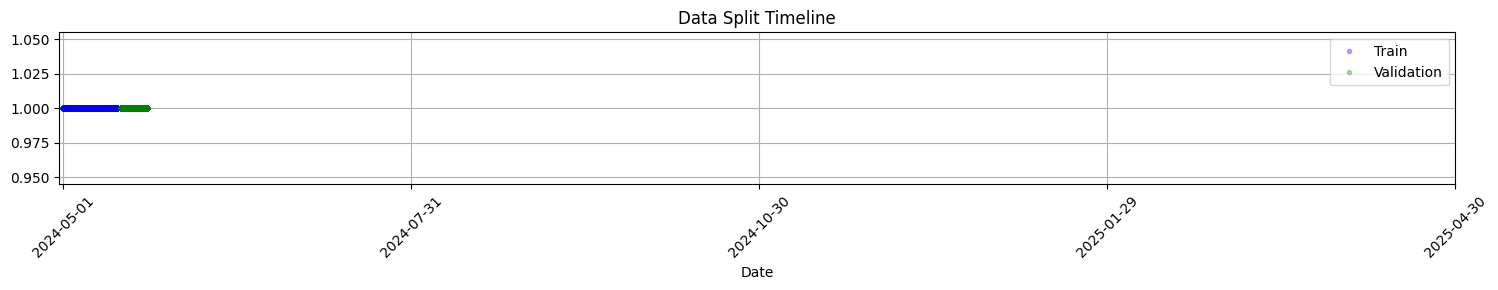

In [17]:
def annualize_factor(sampling: str):
    return ANNUALIZATION.get(sampling, 365*24)

def compute_metrics(equity_curve: pd.Series, sampling: str, turnover_series: pd.Series = None):
    ret = equity_curve.pct_change().dropna()
    ann = annualize_factor(sampling)
    
    # Return metrics
    mu = ret.mean() * ann
    sigma = ret.std() * math.sqrt(ann)
    sharpe = mu / (sigma + 1e-12)
    downside = ret[ret < 0].std() * math.sqrt(ann)
    sortino = mu / (downside + 1e-12)
    
    # Calculate CAGR
    if len(equity_curve) > 1:
        if isinstance(equity_curve.index, pd.DatetimeIndex):
            dt_years = (equity_curve.index[-1] - equity_curve.index[0]).total_seconds() / (365 * 24 * 3600)
        else:
            samples = len(equity_curve)
            samples_per_year = annualize_factor(sampling)
            dt_years = samples / samples_per_year
        dt_years = float(dt_years) if float(dt_years) != 0 else 1e-12
        cagr = (equity_curve.iloc[-1] / equity_curve.iloc[0]) ** (1/dt_years) - 1
    else:
        cagr = 0.0
    
    # Drawdown metrics
    cummax = equity_curve.cummax()
    drawdown = equity_curve / cummax - 1
    maxdd = float(drawdown.min())
    avg_dd = float(drawdown.mean())
    calmar = mu / (abs(maxdd) + 1e-12)
    
    # Trading metrics
    hit_ratio = (ret > 0).mean()
    profit_factor = abs(ret[ret > 0].sum() / ret[ret < 0].sum()) if len(ret[ret < 0]) > 0 else float('inf')
    max_consecutive_losses = max(sum(1 for _ in g) for k, g in itertools.groupby(ret < 0) if k)
    turnover = turnover_series.mean() if turnover_series is not None and len(turnover_series)>0 else np.nan
    
    # Risk metrics
    var_95 = float(np.percentile(ret, 5))  # 95% VaR
    var_99 = float(np.percentile(ret, 1))  # 99% VaR
    cvar_95 = ret[ret <= var_95].mean()  # Conditional VaR (Expected Shortfall)
    
    return {
        "CAGR": cagr, 
        "Sharpe": sharpe, 
        "Sortino": sortino, 
        "MaxDrawdown": maxdd,
        "AvgDrawdown": avg_dd,
        "Calmar": calmar, 
        "Volatility": sigma,
        "VaR_95": var_95,
        "VaR_99": var_99,
        "CVaR_95": cvar_95,
        "HitRatio": hit_ratio,
        "ProfitFactor": profit_factor,
        "MaxConsecutiveLosses": max_consecutive_losses,
        "Turnover": turnover
    }

def plot_series(series: pd.Series, title: str):
    plt.figure(figsize=(10,4))
    plt.plot(series.index, series.values)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

def plot_splits(time_index: pd.DatetimeIndex, train_mask: np.ndarray, val_mask: np.ndarray):
    """Plot timeline showing training and validation periods."""
    plt.figure(figsize=(15,3))
    
    # Convert time index to numeric for plotting
    x = np.arange(len(time_index))
    
    # Plot splits
    plt.plot(x[train_mask], [1]*train_mask.sum(), 'b.', label='Train', alpha=0.3)
    plt.plot(x[val_mask], [1]*val_mask.sum(), 'g.', label='Validation', alpha=0.3)
    
    # Set x-axis ticks to show dates
    tick_locations = np.linspace(0, len(time_index)-1, 5, dtype=int)
    plt.xticks(tick_locations, time_index[tick_locations].strftime('%Y-%m-%d'), rotation=45)
    
    plt.title("Data Split Timeline")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def backtest_env(env: gym.Env, model=None):
    # Get the unwrapped environment
    unwrapped = env.unwrapped if hasattr(env, 'unwrapped') else env
    
    obs, _ = env.reset()
    pv, turns = [], []  # Initialize lists for portfolio value and turnover
    
    for t in range(len(unwrapped.R)-1):
        if model is None:
            action = np.ones(unwrapped.dim_action)/unwrapped.dim_action
        else:
            action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, trunc, info = env.step(action)
        pv.append(info["portfolio_value"])
        turns.append(info["turnover"])
        if done:
            break
            
    idx = pd.RangeIndex(start=0, stop=len(pv), step=1)
    ec = pd.Series(pv, index=idx)
    to = pd.Series(turns, index=idx)
    
    return ec, to

# Plot data splits
print("Visualizing data splits timeline...")
plot_splits(TIME_INDEX, train_mask, val_mask)

Features per observation: 32
Observation dimension: 768
Observation space shape: (768,)
Action space shape: (3,)
Features per observation: 32
Observation dimension: 768
Observation space shape: (768,)
Action space shape: (3,)
Using mps device
Logging to ./tb_logs/PPO_26


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


----------------------------
| time/              |     |
|    fps             | 177 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 64  |
----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 128         |
| train/                  |             |
|    approx_kl            | 0.017839756 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.25       |
|    explained_variance   | -3.34       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0838     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0234     |
|    std                  | 0.997       |
|    value_loss           | 0.0101      |
-----------------------------------------

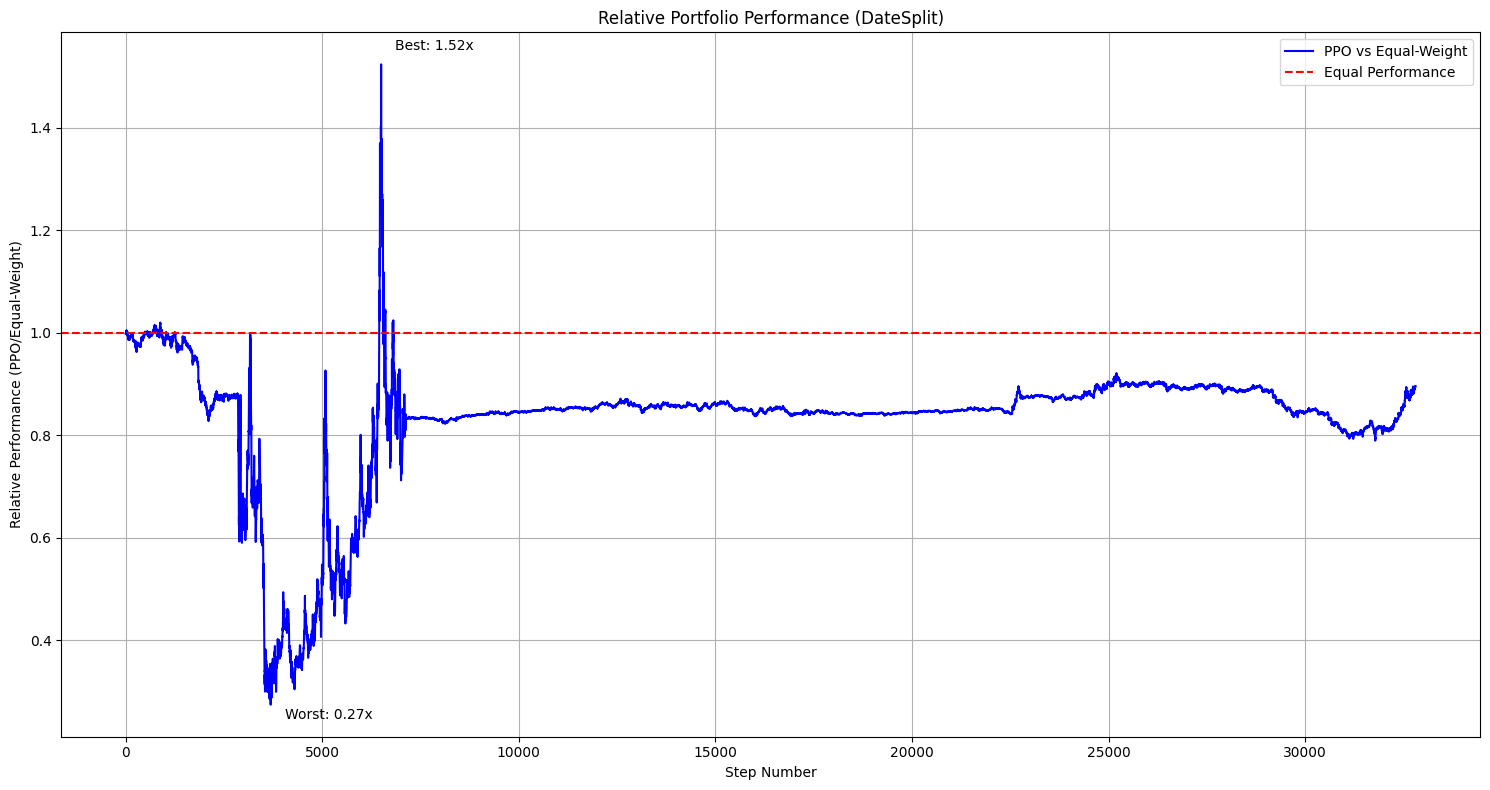

In [18]:
ensure_dir(CONFIG["IO"]["models_dir"])
ensure_dir(CONFIG["EVAL"]["reports_dir"])

RESULTS = []

for split in SPLITS:
    train_env = make_env_from_mask(split["train"], name=f"{split['name']}_train")
    val_env = make_env_from_mask(split["val"], name=f"{split['name']}_val")

    vec_train = DummyVecEnv([lambda: train_env])
    vec_val = DummyVecEnv([lambda: val_env])

    model = PPO(
        policy=CONFIG["RL"]["policy"],
        env=vec_train,
        gamma=CONFIG["RL"]["gamma"],
        gae_lambda=CONFIG["RL"]["gae_lambda"],
        clip_range=CONFIG["RL"]["clip_range"],
        n_steps=CONFIG["RL"]["n_steps"],
        batch_size=CONFIG["RL"]["batch_size"],
        learning_rate=CONFIG["RL"]["learning_rate"],
        ent_coef=CONFIG["RL"]["ent_coef"],
        vf_coef=CONFIG["RL"]["vf_coef"],
        max_grad_norm=CONFIG["RL"]["max_grad_norm"],
        tensorboard_log=CONFIG["IO"]["tb_logdir"],
        device=device,
        verbose=1
    )

    eval_callback = EvalCallback(
        vec_val, 
        best_model_save_path=CONFIG["IO"]["models_dir"],
        log_path=CONFIG["IO"]["models_dir"], 
        eval_freq=10000,
        deterministic=True, 
        render=False
    )
    
    model.learn(total_timesteps=CONFIG["RL"]["timesteps"], callback=eval_callback)
    model_path = os.path.join(CONFIG["IO"]["models_dir"], f"ppo_{split['name']}.zip")
    model.save(model_path)

    # Run validation
    val_env = make_env_from_mask(split["val"], name=f"{split['name']}_val")
    ec, to = backtest_env(val_env, model=model)

    # Compare against equal weight strategy on validation set
    base_env = val_env.unwrapped if hasattr(val_env, "unwrapped") else val_env
    raw_returns = np.asarray(base_env.R)
    if raw_returns.ndim == 1:
        raw_returns = raw_returns.reshape(-1, 1)

    steps = min(len(ec.index) - 1, raw_returns.shape[0])
    if raw_returns.shape[1] == 0 or steps <= 0:
        ec_bench = pd.Series(np.ones(len(ec.index)), index=ec.index)
    else:
        ew = np.ones(raw_returns.shape[1]) / raw_returns.shape[1]
        ec_bench = [1.0]
        for i in range(steps):
            step_ret = float(np.dot(ew, raw_returns[i].reshape(-1)))
            ec_bench.append(ec_bench[-1] * math.exp(step_ret))
        if len(ec_bench) < len(ec.index):
            ec_bench.extend([ec_bench[-1]] * (len(ec.index) - len(ec_bench)))
        ec_bench = pd.Series(ec_bench[:len(ec.index)], index=ec.index)

    # Calculate metrics
    m_model = compute_metrics(ec, CONFIG["DATA"]["sampling"], to)
    m_ew = compute_metrics(ec_bench, CONFIG["DATA"]["sampling"])

    RESULTS.append({
        "split": split["name"], 
        "model": m_model, 
        "equal_weight": m_ew
    })

if CONFIG["EVAL"]["plots"]:
    # Calculate relative performance (PPO vs Equal-Weight)
    relative_performance = ec / ec_bench
    
    # Create step numbers (x-axis)
    steps = np.arange(len(relative_performance))
    
    # Create the plot
    plt.figure(figsize=(15, 8))
    plt.plot(steps, relative_performance.values, 'b-', label='PPO vs Equal-Weight')
    plt.axhline(y=1.0, color='r', linestyle='--', label='Equal Performance')
    
    plt.title(f"Relative Portfolio Performance ({split['name']})")
    plt.xlabel("Step Number")
    plt.ylabel("Relative Performance (PPO/Equal-Weight)")
    plt.legend()
    plt.grid(True)
    
    # Add annotations for key points
    best_point = np.argmax(relative_performance.values)
    worst_point = np.argmin(relative_performance.values)
    
    plt.annotate(f'Best: {relative_performance.values[best_point]:.2f}x',
                xy=(steps[best_point], relative_performance.values[best_point]),
                xytext=(10, 10), textcoords='offset points')
    
    plt.annotate(f'Worst: {relative_performance.values[worst_point]:.2f}x',
                xy=(steps[worst_point], relative_performance.values[worst_point]),
                xytext=(10, -10), textcoords='offset points')
    
    plt.tight_layout()
    plt.show()

In [19]:
# Create a DataFrame with all results
rows = []
for res in RESULTS:
    row = {"split": res["split"]}
    for k, metrics in res.items():
        if k == "split":
            continue
        for mname, mval in metrics.items():
            row[f"{k}_{mname}"] = mval
    rows.append(row)

df_results = pd.DataFrame(rows)

column_order = ['split']
for model_type in ['model', 'equal_weight']:
    for metric in ['CAGR', 'Sharpe', 'Sortino', 'Calmar',
                   'MaxDrawdown', 'Volatility', 'Turnover', 'HitRatio']:
        col = f"{model_type}_{metric}"
        if col in df_results.columns:
            column_order.append(col)
    if model_type == 'model':
        for metric in ['Avg_Leverage', 'Max_Leverage']:
            col = f"{model_type}_{metric}"
            if col in df_results.columns:
                column_order.append(col)

df_results = df_results[column_order]

num_cols = df_results.select_dtypes(include='number').columns
fmt = {col: "{:.4f}" for col in num_cols}
display(df_results.style.format(fmt))

,split,model_CAGR,model_Sharpe,model_Sortino,model_Calmar,model_MaxDrawdown,model_Volatility,model_Turnover,model_HitRatio,equal_weight_CAGR,equal_weight_Sharpe,equal_weight_Sortino,equal_weight_Calmar,equal_weight_MaxDrawdown,equal_weight_Volatility,equal_weight_Turnover,equal_weight_HitRatio
0,DateSplit,-0.9241,0.3269,0.3344,1.7113,-0.5001,2.6179,0.0001,0.4915,-0.5754,0.9814,1.0718,4.2436,-0.6064,2.6222,nan,0.4915


In [20]:
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
ensure_dir(CONFIG["EVAL"]["reports_dir"])
out_json = os.path.join(CONFIG["EVAL"]["reports_dir"], f"metrics_{ts}.json")
out_csv  = os.path.join(CONFIG["EVAL"]["reports_dir"], f"metrics_{ts}.csv")
df_results.to_csv(out_csv, index=False)


def to_serializable(obj):
    if isinstance(obj, np.generic):
        return obj.item()
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    raise TypeError(f"Unhandled type: {type(obj)}")

with open(out_json, "w") as f:
    json.dump(RESULTS, f, indent=2, default=to_serializable)

print("Saved:", out_json, "and", out_csv)

Saved: ./reports/metrics_20251031_123119.json and ./reports/metrics_20251031_123119.csv


# Model Inference

Let's load the trained model and run inference on it. This section demonstrates how to:
1. Load the saved model
2. Create an environment for inference
3. Run the model on new data
4. Visualize the results

In [ ]:
# Load the best trained model
model_path = os.path.join(CONFIG["IO"]["models_dir"], "best_model.zip")
loaded_model = PPO.load(model_path)

# Create a new environment for inference (using validation data as an example)
inference_env = make_env_from_mask(split["val"], name="inference_env")

# Function to run inference and collect predictions
def run_inference(model, env):
    obs, _ = env.reset()
    done = False
    
    predictions = []
    actual_returns = []
    portfolio_values = []
    actions_taken = []
    
    while not done:
        # Get model's prediction
        action, _ = model.predict(obs, deterministic=True)
        
        # Take the action in the environment
        obs, reward, done, _, info = env.step(action)
        
        # Store results
        predictions.append(info["pair_return"])  # Predicted return
        actual_returns.append(reward)  # Actual return
        portfolio_values.append(info["portfolio_value"])
        actions_taken.append(action)
    
    return {
        "predictions": np.array(predictions),
        "actual_returns": np.array(actual_returns),
        "portfolio_values": np.array(portfolio_values),
        "actions": np.array(actions_taken)
    }

# Run inference
results = run_inference(loaded_model, inference_env)

# Plot the results
plt.figure(figsize=(15, 12))

# Portfolio Value Plot
plt.subplot(3, 1, 1)
plt.plot(results["portfolio_values"], label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Actions Plot
plt.subplot(3, 1, 2)
plt.plot(results["actions"], label=['Asset 1', 'Asset 2'])
plt.title('Model Actions (Position Sizes)')
plt.xlabel('Time Step')
plt.ylabel('Position Size')
plt.legend()
plt.grid(True)

# Returns Plot
plt.subplot(3, 1, 3)
plt.plot(results["actual_returns"], label='Actual Returns', alpha=0.6)
plt.plot(results["predictions"], label='Predicted Returns', alpha=0.6)
plt.title('Returns Analysis')
plt.xlabel('Time Step')
plt.ylabel('Return')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nInference Summary:")
print(f"Total Steps: {len(results['predictions'])}")
print(f"Final Portfolio Value: {results['portfolio_values'][-1]:.4f}")
print(f"Average Position Size (Asset 1): {np.mean(abs(results['actions'][:, 0])):.4f}")
print(f"Average Position Size (Asset 2): {np.mean(abs(results['actions'][:, 1])):.4f}")
print(f"Average Return: {np.mean(results['actual_returns']):.4f}")
print(f"Sharpe Ratio: {np.mean(results['actual_returns']) / (np.std(results['actual_returns']) + 1e-10):.4f}")